In [1]:
!ls

02-data_wrangling.ipynb        04-Modeling_Prophet.ipynb
03-pre-processing.ipynb        04-modeling.ipynb
04-Modeling-Stacked_LSTM.ipynb Capstone3-Colab.ipynb
04-Modeling_LSTM.ipynb         stock_market.csv


### Modeling - Facebook Prophet
Company: Bharat Petroleum Corporation Ltd.,ENERGY,BPCL,EQ,INE029A01011
The VWAP (Volume Weighted Average Price) is the target variable to predict. 
VWAP is a trading benchmark used by traders that gives the average price the 
stock has traded at throughout the day, based on both volume and price. 
References: 
1. https://www.kaggle.com/yashvi/time-series-analysis-and-forecasting-reliance
2. https://www.kaggle.com/parulpandey/getting-started-with-time-series-using-pandas/notebook
3. https://www.kaggle.com/sinjoysaha/stock-price-forecasting-using-stacked-lstm/notebook
4. https://www.kaggle.com/rohanrao/a-modern-time-series-tutorial
5. https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
6. https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
7. https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
import pandas as pd
df = pd.read_csv('stock_market.csv')
df.drop(['Time.1'], axis = 1, inplace=True)
df.set_index('Time', inplace=True, drop=True)

In [2]:
# Train-test-split
# Split the data into train_data and test_data
from sklearn.model_selection import train_test_split
y = df[['VWAP']]
X = df.drop(['VWAP'], axis=1)

features = ['Prev Close','Open', 'High', 'Low',
       'Last', 'Close',
       'Volume', 'Turnover', 'Deliverable Volume',
       '%Deliverble']
rows = X.index

y1 = pd.DataFrame(y, columns=['VWAP'], index=X.index)
X1 = pd.DataFrame(X, columns=features, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.20, random_state=42)

In [4]:
# Standardize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fit only to the training data
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
# Now apply the transformations to the test data
X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test)
df = scaler.transform(df)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [5]:
import sys
sys.path.append('/Users/elinorvelasquez/anaconda3/lib/python3.8/site-packages/')
!conda install -c anaconda fbprophet -y

Solving environment: done

# All requested packages already installed.



In [6]:
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')

df_fb = pd.read_csv('stock_market.csv', date_parser=parse)
df_fb.drop(['Time.1'], axis = 1, inplace=True)
df_prophet = df_fb[['Time', 'VWAP']]

In [7]:
df_prophet.rename(columns={'Time':'ds', 'VWAP':'y'}, inplace=True)
df_prophet.head(3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ds,y
0,2000-01-03,399.32
1,2000-01-04,375.71
2,2000-01-05,359.96


In [9]:
from fbprophet import Prophet
prophets = Prophet()
prophets.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = prophets.make_future_dataframe(periods=365)
forecast = prophets.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5666,2022-04-26,280.237821,152.813682,394.953521
5667,2022-04-27,278.369824,152.899043,404.405103
5668,2022-04-28,277.343973,141.681221,403.169968
5669,2022-04-29,275.912311,141.451774,404.439340
5670,2022-04-30,286.141817,161.342551,414.518201


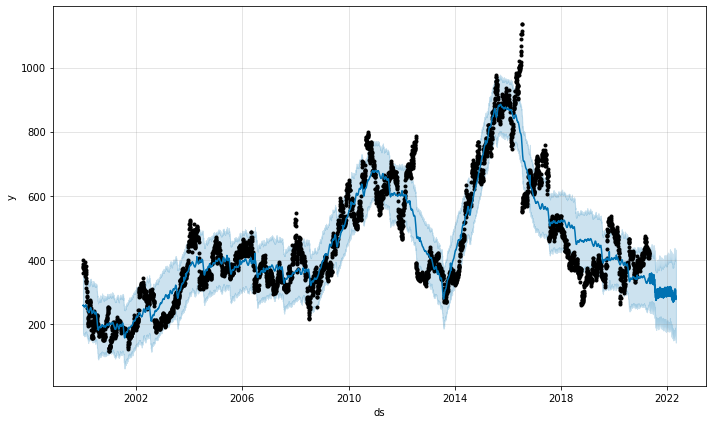

In [11]:
fig1 = prophets.plot(forecast)

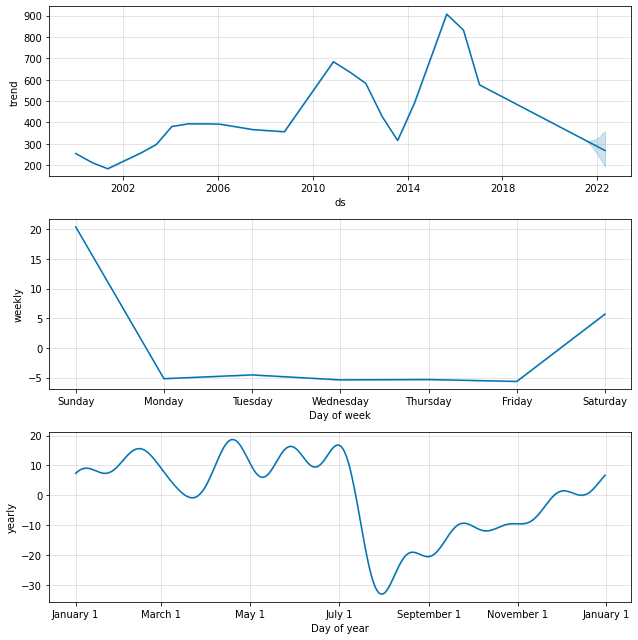

In [12]:
fig2 = prophets.plot_components(forecast)

In [13]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophets, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 38 forecasts with cutoffs between 2002-02-04 00:00:00 and 2020-04-30 00:00:00


In [14]:
df_cv.head(3)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-02-05,220.125563,197.977383,242.932557,244.09,2002-02-04
1,2002-02-06,221.112741,198.850730,244.306541,283.80,2002-02-04
2,2002-02-07,221.459181,199.356576,245.420321,310.86,2002-02-04


In [15]:
from fbprophet.diagnostics import performance_metrics
df_per = performance_metrics(df_cv)
df_per.head(3)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,20737.466729,144.005093,106.980930,0.215207,0.171580,0.427636
1,37 days,20929.848961,144.671521,107.628227,0.216621,0.172627,0.426214
2,38 days,21056.506953,145.108604,108.057783,0.217491,0.173124,0.423746


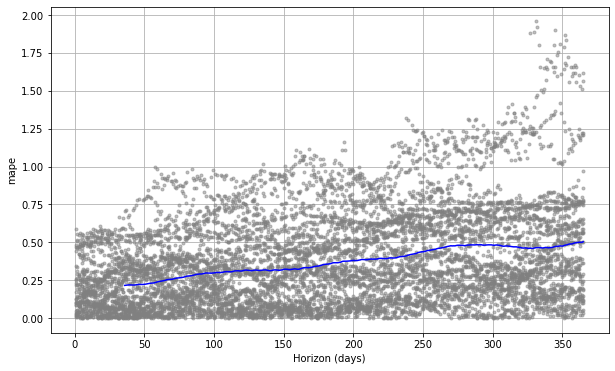

In [44]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape') # Mean Absolute Percentage Error

INFO:fbprophet:Making 20 forecasts with cutoffs between 2001-11-06 00:00:00 and 2020-11-01 00:00:00



  horizon           mse        rmse         mae      mape     mdape  coverage
0 19 days  24867.956812  157.695773  114.913316  0.241599  0.161142  0.397747
1 20 days  25099.110326  158.426987  116.021946  0.244771  0.164150  0.389350
2 21 days  25827.434992  160.709163  118.011394  0.246175  0.166175  0.375519


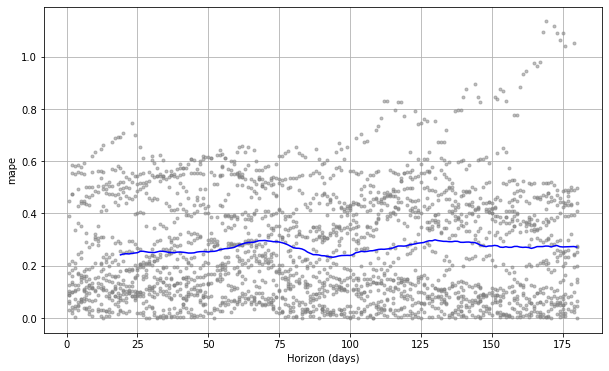

In [16]:
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(prophets, initial='365.25 days', period='365 days', horizon = '180 days')

from fbprophet.diagnostics import performance_metrics
df_per = performance_metrics(df_cv2)
print(df_per.head(3))

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='mape')